In [1]:
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import pandas as pd

plt.style.use("ggplot")

In [2]:
eng = nivapy.da.connect_postgis()

Connection successful.


# Quantom: Landing permit maps

Generating simple maps showing sites of interest for use in applications for helicopter landing permits.

## 1. Read sites

In [3]:
xl_path = "../data/tana_subcatchments_2021.xlsx"
stn_df = pd.read_excel(xl_path, sheet_name="Sheet1")

# Get just stations of interest and assign unique ID
stn_df = stn_df.query("include == 1")
stn_df.reset_index(inplace=True, drop=True)
stn_df.reset_index(inplace=True)

# Add UTM co-ords (Zone 35 for Finnmark)
stn_df = nivapy.spatial.wgs84_dd_to_utm(stn_df, lat="lat", lon="lon", utm_zone="35")

stn_df

,index,site_name,lat,lon,include,comment,utm_north,utm_east,utm_zone
0,0,Njahkajavri,68.883247,23.752543,1,NaN,7.644795e+06,369483.645587,35
1,1,Vuomajeaggi,68.967342,24.078032,1,NaN,7.653506e+06,383002.473802,35
2,2,Caskin-jeaggi / Caskinjohka,68.945610,25.509712,1,NaN,7.649023e+06,440254.823752,35
3,3,Juovvajohka,69.104383,24.444347,1,NaN,7.668121e+06,398298.619553,35
4,4,Fáhttevárleakšá,69.609378,24.959789,1,NaN,7.723637e+06,420679.502249,35
5,5,Leavvajohka,69.876857,25.926961,1,NaN,7.752503e+06,458801.013035,35
6,6,Gurrojohka,69.965256,26.077548,1,NaN,7.762265e+06,464731.412879,35
7,7,Jeakkášjávri,70.140608,27.615827,1,NaN,7.781671e+06,523348.120382,35
8,8,Ovddaldasvárri,69.964763,26.915793,1,NaN,7.761946e+06,496780.282963,35


## 2. Assign stations to kommuner

<AxesSubplot:>

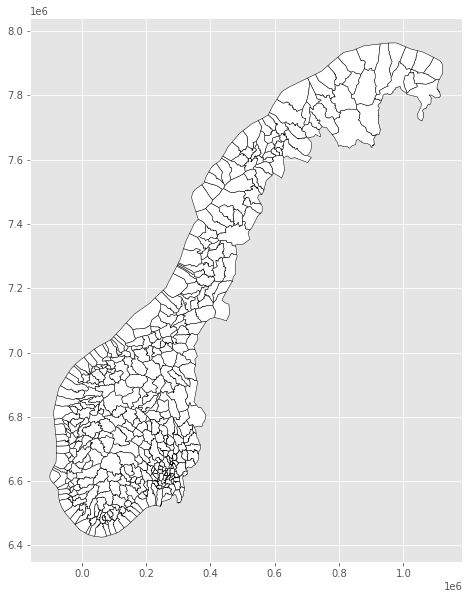

In [4]:
# Get kommuner boundaries
kom_gdf = nivapy.da.read_postgis(
    "cultural", "norway_kartverket_kommuner_2019_poly", eng
)
kom_gdf.plot(facecolor="white", edgecolor="black", figsize=(10, 10))

In [5]:
# Assign points to polys
stn_df = nivapy.spatial.identify_point_in_polygon(
    stn_df, kom_gdf, "index", "kommunenummer", lat_col="lat", lon_col="lon"
)

# Assign names to kommune IDs
kom_names_dict = {
    "2011": "Kautokeino",
    "2021": "Karasjok",
    "2025": "Tana",
}
stn_df["kom_name"] = stn_df["kommunenummer"].map(kom_names_dict)

# Assign colours to kommune IDs
kom_cols_dict = {
    "2011": "r",
    "2021": "b",
    "2025": "g",
}
stn_df["colour"] = stn_df["kommunenummer"].map(kom_cols_dict)

# Sort and re-assign more sensible site IDs
stn_df.sort_values(["kommunenummer", "utm_north"], inplace=True)
del stn_df["index"]
stn_df.reset_index(inplace=True, drop=True)
stn_df.reset_index(inplace=True)
stn_df["site_id"] = stn_df["index"] + 1
del stn_df["index"]

# Save
stn_df.to_csv(r"../output/permit_maps/permits_sept2021_all_sites.csv")

stn_df

,site_name,lat,lon,include,comment,utm_north,utm_east,utm_zone,kommunenummer,kom_name,colour,site_id
0,Njahkajavri,68.883247,23.752543,1,NaN,7.644795e+06,369483.645587,35,2011,Kautokeino,r,1
1,Vuomajeaggi,68.967342,24.078032,1,NaN,7.653506e+06,383002.473802,35,2011,Kautokeino,r,2
2,Juovvajohka,69.104383,24.444347,1,NaN,7.668121e+06,398298.619553,35,2011,Kautokeino,r,3
3,Caskin-jeaggi / Caskinjohka,68.945610,25.509712,1,NaN,7.649023e+06,440254.823752,35,2021,Karasjok,b,4
4,Fáhttevárleakšá,69.609378,24.959789,1,NaN,7.723637e+06,420679.502249,35,2021,Karasjok,b,5
5,Leavvajohka,69.876857,25.926961,1,NaN,7.752503e+06,458801.013035,35,2025,Tana,g,6
6,Ovddaldasvárri,69.964763,26.915793,1,NaN,7.761946e+06,496780.282963,35,2025,Tana,g,7
7,Gurrojohka,69.965256,26.077548,1,NaN,7.762265e+06,464731.412879,35,2025,Tana,g,8
8,Jeakkášjávri,70.140608,27.615827,1,NaN,7.781671e+06,523348.120382,35,2025,Tana,g,9


## 3. Plots

### 3.1. All points on a single map

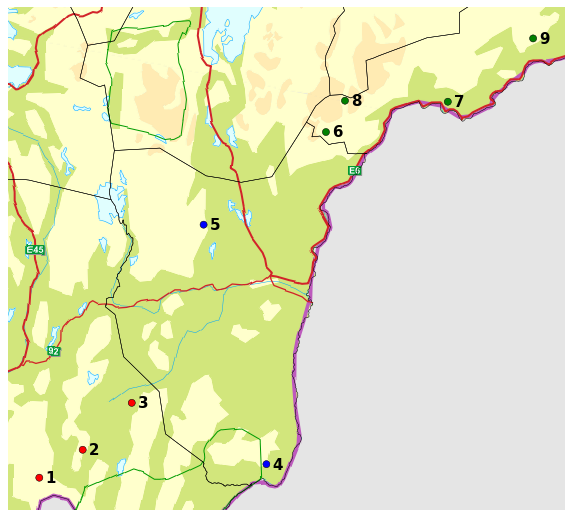

In [6]:
buff = 10000
fig = plt.figure(figsize=(10, 10))

crs = ccrs.UTM(35)

# Plot
ax = fig.add_subplot(1, 1, 1, projection=crs)
ax.set_extent(
    [
        stn_df["utm_east"].min() - buff,
        stn_df["utm_east"].max() + buff,
        stn_df["utm_north"].min() - buff,
        stn_df["utm_north"].max() + buff,
    ],
    crs=crs,
)

ax.add_wms(wms="https://openwms.statkart.no/skwms1/wms.topo4", layers=["topo4_WMS"])

ax.add_geometries(
    kom_gdf.to_crs(25835)["geom"], crs=crs, facecolor="none", edgecolor="black"
)

ax.scatter(
    stn_df["utm_east"],
    stn_df["utm_north"],
    s=50,
    c=stn_df["colour"],
    edgecolors="k",
    transform=crs,
)

for idx, row in stn_df.iterrows():
    ax.text(
        row["utm_east"] + 2000,
        row["utm_north"],
        row["site_id"],
        size=15,
        weight="bold",
        ha="left",
        va="center",
        transform=crs,
    )

# Save
out_png = r"../output/permit_maps/permits_sept2021_all_sites.png"
plt.savefig(out_png, dpi=200, bbox_inches="tight")

### 3.2. By Kommune

#### 3.2.1. Kommune overview maps

In [7]:
buff = 3000
crs = ccrs.UTM(35)

for kom_no in stn_df["kommunenummer"].unique():
    fig = plt.figure(figsize=(10, 10))

    stn_kom_df = stn_df.query("kommunenummer == @kom_no").copy()

    # Plot
    ax = fig.add_subplot(1, 1, 1, projection=crs)
    ax.set_extent(
        [
            stn_kom_df["utm_east"].min() - buff,
            stn_kom_df["utm_east"].max() + buff,
            stn_kom_df["utm_north"].min() - buff,
            stn_kom_df["utm_north"].max() + buff,
        ],
        crs=crs,
    )

    ax.add_wms(wms="https://openwms.statkart.no/skwms1/wms.topo4", layers=["topo4_WMS"])

    ax.scatter(
        stn_kom_df["utm_east"],
        stn_kom_df["utm_north"],
        s=50,
        c=stn_kom_df["colour"],
        edgecolors="k",
        transform=crs,
    )

    for idx, row in stn_kom_df.iterrows():
        ax.text(
            row["utm_east"] + 1000,
            row["utm_north"],
            row["site_id"],
            size=15,
            weight="bold",
            ha="left",
            va="center",
            transform=crs,
        )

    # Save
    out_png = f"../output/permit_maps/permits_sept2021_kom{kom_no}.png"
    plt.savefig(out_png, dpi=200, bbox_inches="tight")
    plt.close()

#### 3.2.2. Site detail gridplot

In [8]:
buff = 2000
crs = ccrs.UTM(35)

fig = plt.figure(figsize=(15, 15))

for idx, row in stn_df.iterrows():
    ax = fig.add_subplot(3, 3, idx + 1, projection=crs)
    ax.set_extent(
        [
            row["utm_east"] - buff,
            row["utm_east"] + buff,
            row["utm_north"] - buff,
            row["utm_north"] + buff,
        ],
        crs=crs,
    )

    ax.add_wms(wms="https://openwms.statkart.no/skwms1/wms.topo4", layers=["topo4_WMS"])

    ax.scatter(
        row["utm_east"],
        row["utm_north"],
        s=50,
        c=row["colour"],
        edgecolors="k",
        transform=crs,
    )

    ax.set_title("%s. %s" % (row["site_id"], row["site_name"]), fontsize=12)

# Save
out_png = f"../output/permit_maps/permits_sept2021_all_sites_gridplot.png"
plt.savefig(out_png, dpi=200, bbox_inches="tight")
plt.close()